<a href="https://colab.research.google.com/github/Fisherboy927/L2O/blob/main/SAMBa_L2O.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os, pathlib, itertools

!pip install astra-toolbox
!pip install --quiet odl
!pip install scikit-image
!unzip -q "/content/drive/MyDrive/CTDataset.zip" -d "/content/CTDataset_unzipped"
base = pathlib.Path("/content/CTDataset_unzipped")
all_imgs = list(base.rglob("*.png"))
train_imgs = random.sample(all_imgs, 200)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 895.7/895.7 kB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 MB 7.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-cufft-cu12
    Found existing installation: nvidia-cufft-cu12 11.3.0.4
    Uninstalling nvidia-cufft-cu12-11.3.0.4:
      Successfully uninstalled nvidia-cufft-cu12-11.3.0.4
  Attempting uninstall: nvidia-cuda-runtime-cu12
    Found existing installation: nvidia-cuda-runtime-cu12 12.6.77
    Uninstalling nvidia-cuda-runtime-cu12-12.6.77:
      Successfully uninstalled nvidia-cuda-runtime-cu12-12.6.77
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.8.0+cu126 requires nvidia-cuda-runtime-cu12==12.6.77; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-ru

In [6]:
import odl
from odl import uniform_discr
from odl.tomo import parallel_beam_geometry, RayTransform
from odl.contrib.torch import OperatorModule
import torch
import astra

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch_dtype = torch.float64

n= 256 ## for a 256 x 256 ground-truth image
n_angles = 180 ## just a choice, I'd recommend just keeping this

space = odl.uniform_discr([-n//2,-n//2], [n//2,n//2], shape=[n,n], weighting=1.0)

geometry = odl.tomo.parallel_beam_geometry(space, num_angles=n_angles, det_shape=int(np.ceil(np.sqrt(2)*n)))

## in the below, the 'astra_cuda' setting means it is on GPU. (I think you can use GPU or colab. At least you can pretty cheaply buy some GPU use.) For now you can just remove this input in the function below and it will just use CPU and be slower.

T = odl.tomo.RayTransform(space, geometry, impl='astra_cuda')

T_norm = T.norm(estimate=True) ## this calculates the operator norm of T
T = T / T_norm ### normalising so \|T\| = 1.
T_norm = T.norm(estimate=True)
print('T NORM IS ', T.norm(estimate=True))

forward_operator = OperatorModule(T).to(device, dtype=torch_dtype)#.double()
adjoint_operator = OperatorModule(T.adjoint).to(device, dtype=torch_dtype)#.double()

T NORM IS  1.00000006399


In [7]:
def huber(s: torch.Tensor, epsilon: float = 0.01) -> torch.Tensor:
    """Compute the Huber loss element-wise.

    Args:
    - s: The input tensor.
    - epsilon: The threshold value for the Huber loss. Defaults to 0.01.

    Returns:
    - The element-wise Huber loss tensor.

    Raises:
    - ValueError: If the input tensor is not a torch.Tensor.
    """
    if not isinstance(s, torch.Tensor):
        raise ValueError("Input 's' to function huber() must be a torch.Tensor")

    if epsilon <= 0:
        raise ValueError("'epsilon' in function huber() must be greater than zero.")

    return torch.where(
        torch.abs(s) <= epsilon,
        (0.5 * s ** 2) / epsilon,
        torch.abs(s) - 0.5 * epsilon
    )

def fast_huber_TV(x, alpha, delta=0.01):
    ## in a batch it just adds all individuals up
    tv_h = huber(x[:, :, 1:,:]-x[:, :, :-1,:], delta).sum()
    tv_w = huber(x[:, :, :,1:]-x[:, :, :,:-1], delta).sum()
    huber_tv = (tv_h+tv_w)
    return alpha*huber_tv

def fast_huber_grad(x, alpha, delta=0.01):
    # Extract height and width dimensions
    height, width = x.shape[2:]
    batch_size = x.shape[0]
    diff_y = torch.cat((x[:, :, 1:, :] - x[:, :, :-1, :], torch.zeros(batch_size, 1, 1, width, dtype=x.dtype).to(x.device)), dim=2)
    diff_x = torch.cat((x[:, :, :, 1:] - x[:, :, :, :-1], torch.zeros(batch_size, 1, height, 1, dtype=x.dtype).to(x.device)), dim=3)
    delta_ones = delta * torch.ones_like(diff_y)
    max_diff_delta1 = torch.max(torch.abs(diff_y), delta_ones)
    max_diff_delta2 = torch.max(torch.abs(diff_x), delta_ones)
    penult1 = diff_y / max_diff_delta1
    penult2 = diff_x / max_diff_delta2
    f1 = torch.cat((-penult1[:, :, 0, :].unsqueeze(-2), -penult1[:, :, 1:, :] + penult1[:, :, :-1, :]), dim=2)
    f2 = torch.cat((-penult2[:, :, :, 0].unsqueeze(-1), -penult2[:, :, :, 1:] + penult2[:, :, :, :-1]), dim=3)
    result = alpha * (f1 + f2)
    return result

a = 0.001

def f(x, y): #training data
    return 0.5 * torch.norm(forward_operator(x)-y)**2 + fast_huber_TV(x, a)

def grad_f(x, y):
    return adjoint_operator(forward_operator(x)-y) + fast_huber_grad(x, a)

print(1/(T_norm + 8*a/0.01))

0.555555476191


100%|██████████| 8/8 [00:57<00:00,  7.17s/it]


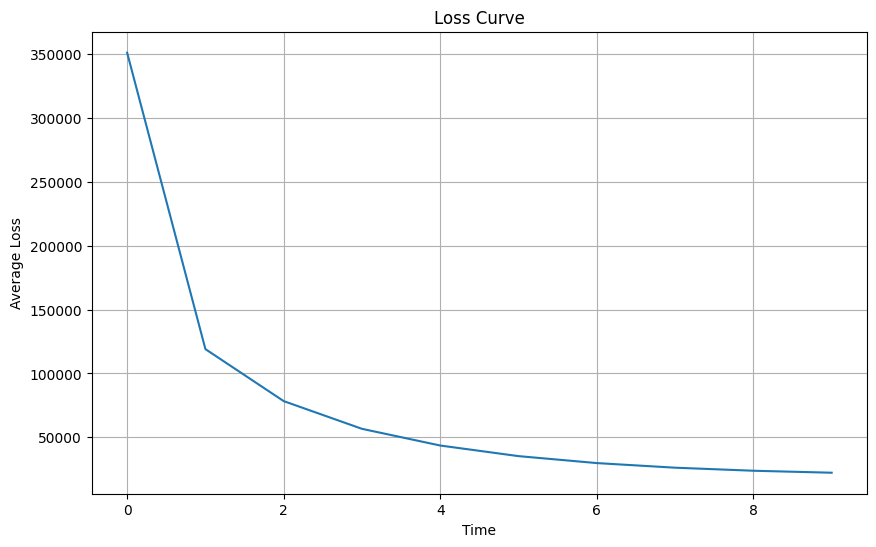

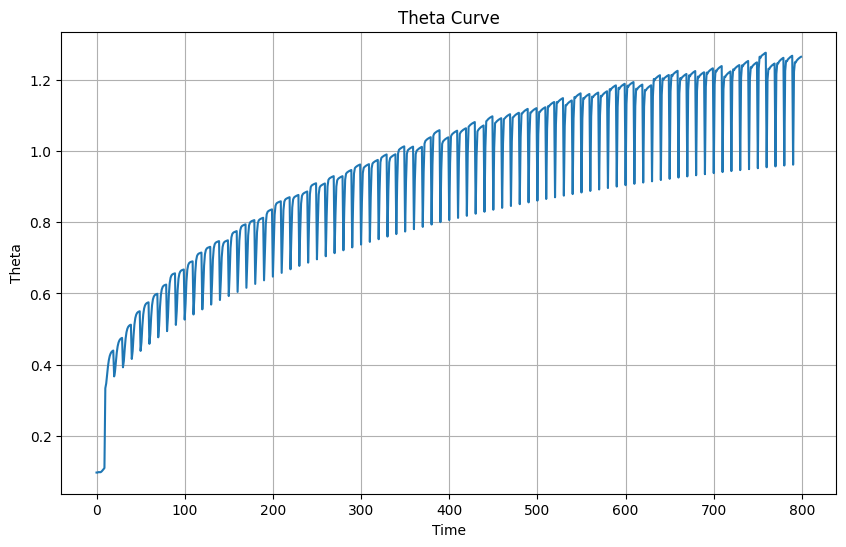

In [8]:
import matplotlib.pyplot as plt
from skimage.color import rgb2gray, rgba2rgb
from skimage import io
from skimage.transform import radon,iradon,resize
from skimage.io import imread
from pathlib import Path
from tqdm import tqdm
import math
import odl.contrib.torch.operator as _op
from torch.utils.data import Dataset, DataLoader
from torch import nn
_op.AVOID_UNNECESSARY_COPY = False

epoch = 10
M = 10
n = 256
sigma = 0.001

class CTDataset(Dataset):
    def __init__(self, paths, n, device, dtype):
        self.paths = paths
        self.n = n
        self.device = device
        self.dtype = dtype

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        im = io.imread(path)
        if im.ndim == 3 and im.shape[-1] == 4:
           im = rgba2rgb(im)
        im = rgb2gray(im)
        image = resize(im, (n, n))
        x = torch.from_numpy(image).to(device=self.device, dtype=self.dtype) # Use self.device and self.dtype
        x = x.unsqueeze(0)
        return x

class NeuralNetwork1(nn.Module):
    def __init__(self, in_channels=1, out_dim=1):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),      # 256x256 -> 128x128

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),      # 128x128 -> 64x64
        )
        self.gap   = nn.AdaptiveAvgPool2d(1)  # -> (B, 64, 1, 1)
        self.head  = nn.Linear(64, out_dim)   # -> (B, out_dim)

    def forward(self, x):
        # x expected shape: (B, in_channels, 256, 256)
        x = self.features(x)         # (B, 64, 64, 64)
        x = self.gap(x).flatten(1)   # (B, 64)
        x = self.head(x)             # (B, out_dim)
        return x

dataset = CTDataset(train_imgs, n, device, dtype=torch_dtype)
loader = DataLoader(dataset, batch_size = 25, shuffle = True)
model1 = NeuralNetwork1().to(device=device, dtype=torch_dtype)
theta1_list = []
optimizer = torch.optim.SGD(model1.parameters(), lr=1e-8)
loss_history1 = []

for t in range(epoch):
    L_i_list = []
    for x_batch in tqdm(loader):
        L_i = torch.zeros((), device=device, dtype=torch_dtype)
        x = torch.zeros_like(x_batch)
        sinogram_batch = forward_operator(x_batch)
        sinogram_batch_noisy = sinogram_batch + torch.randn_like(sinogram_batch)* sigma
        for k in range(1, M+1):
            g0 = grad_f(x, sinogram_batch_noisy)
            # theta will have shape [batch_size, 1]. Need to unsqueeze to [batch_size, 1, 1, 1] for element-wise multiplication
            theta1 = model1(x)
            theta1_list.append(theta1.mean().item())
            x = x - theta1.unsqueeze(-1).unsqueeze(-1) * g0
            L_i = L_i + f(x, sinogram_batch_noisy)
        L_i_list.append(L_i.item())
        optimizer.zero_grad()
        L_i.backward()
        optimizer.step()
    L = sum(L_i_list)/len(L_i_list)
    loss_history1.append(L)

plt.figure(figsize=(10, 6))
plt.plot(loss_history1)
plt.xlabel('Time')
plt.ylabel('Average Loss')
plt.title('Loss Curve')
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(theta1_list)
plt.xlabel('Time')
plt.ylabel('Theta')
plt.title('Theta Curve')
plt.grid(True)
plt.show()

Grid Search for Theta: 100%|██████████| 20/20 [04:10<00:00, 12.50s/it]


Best theta found: 1.5818710327148438
Minimum loss with best theta: 269699.26427123585


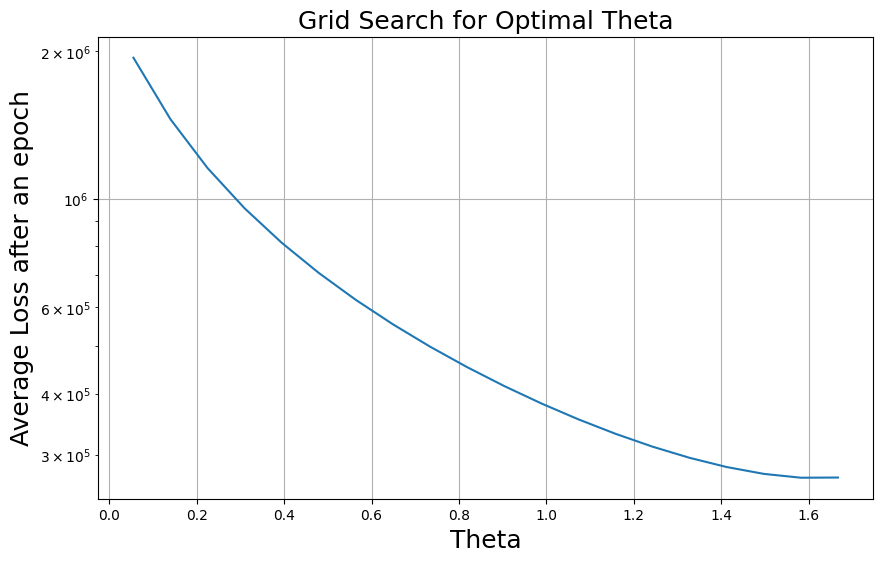

In [9]:
import matplotlib.pyplot as plt
from skimage.color import rgb2gray, rgba2rgb
from skimage import io
from skimage.transform import radon,iradon,resize
from skimage.io import imread
from pathlib import Path
from tqdm import tqdm
import math
import odl.contrib.torch.operator as _op
from torch.utils.data import Dataset, DataLoader
from torch import nn
_op.AVOID_UNNECESSARY_COPY = False

class CTDataset(Dataset):
    def __init__(self, paths, n, device, dtype):
        self.paths = paths
        self.n = n
        self.device = device
        self.dtype = dtype

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        im = io.imread(path)
        if im.ndim == 3 and im.shape[-1] == 4:
           im = rgba2rgb(im)
        im = rgb2gray(im)
        image = resize(im, (n, n))
        x = torch.from_numpy(image).to(device=device, dtype=torch_dtype)
        x = x.unsqueeze(0)
        return x

dataset = CTDataset(train_imgs, n, device, dtype=torch_dtype)
loader = DataLoader(dataset, batch_size = 25, shuffle = True)

# Define the grid of theta values to search over
grid_search_array = torch.linspace(0.1/(T_norm+8*a/0.01), 3/(T_norm+8*a/0.01), 20).to(device, dtype=torch_dtype)

best_theta = None
min_loss = float('inf')
loss_history = []
L_i_list = []

# Perform grid search
for current_theta in tqdm(grid_search_array, desc="Grid Search for Theta"):
    for x_batch in loader:
        L_i = 0
        x = torch.zeros_like(x_batch)
        sinogram_batch = forward_operator(x_batch)
        sinogram_batch_noisy = sinogram_batch + torch.randn_like(sinogram_batch)* sigma

        for k in range(1, M+1):
            g0 = grad_f(x, sinogram_batch_noisy)
            x = x - current_theta * g0
            L_i += f(x, sinogram_batch_noisy).item()
        L_i_list.append(L_i)
    L = sum(L_i_list)/len(L_i_list)
    loss_history.append(L)
    if L < min_loss:
        min_loss = L
        best_theta = current_theta

print(f"Best theta found: {best_theta.item()}")
print(f"Minimum loss with best theta: {min_loss}")

# Plot the loss for each theta in the grid
plt.figure(figsize=(10, 6))
plt.semilogy(grid_search_array.cpu().numpy(), loss_history)
plt.xlabel('Theta', fontsize = 18)
plt.ylabel('Average Loss after an epoch', fontsize = 18)
plt.title('Grid Search for Optimal Theta', fontsize = 18)
plt.grid(True)
plt.show()


# Now you can use the best_theta for further analysis or reconstruction
theta2 = best_theta # Assign the best theta to the variable used later

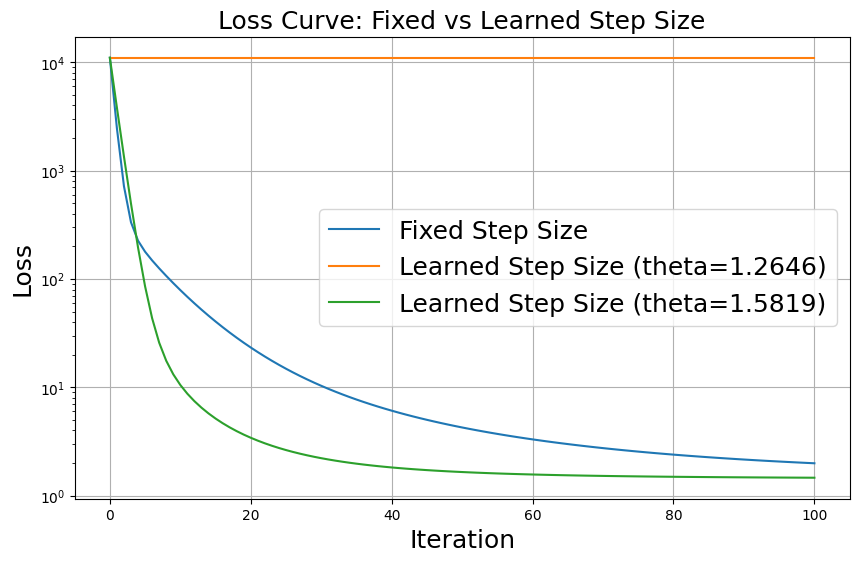

In [10]:
function_value_list_fixed, function_value_list_learned = [], []
num_comparison_iterations = 100

test_imgs = random.sample(all_imgs, 10)
num_images = len(test_imgs)

fixed_step_size = 1/(T_norm+8*a/0.01)

all_fixed_losses = []
all_learned_losses = []

for image_path in test_imgs:
    im = io.imread(image_path)
    if im.ndim == 3 and im.shape[-1] == 4:
        im = rgba2rgb(im)
    im = rgb2gray(im)
    image = resize(im, (n, n))
    x = torch.from_numpy(image).to(device=device, dtype=torch_dtype)
    x = x.unsqueeze(0).unsqueeze(0)
    sinogram = forward_operator(x)
    sinogram_noisy = sinogram + torch.randn_like(sinogram) * sigma

    x_test = torch.zeros_like(x)

    # We need two separate copies to update, so they don't interfere
    x_for_fixed_update = x_test.clone()
    x_for_learned_update1 = x_test.clone()
    x_for_learned_update2 = x_test.clone()

    fixed_losses = [f(x_for_fixed_update, sinogram_noisy).item()]
    learned_losses1 = [f(x_for_learned_update1, sinogram_noisy).item()]
    learned_losses2 = [f(x_for_learned_update2, sinogram_noisy).item()]

    # Fixed step size update
    for i in range(num_comparison_iterations):
        g1 = grad_f(x_for_fixed_update, sinogram_noisy)
        x_for_fixed_update = x_for_fixed_update - fixed_step_size * g1
        fixed_losses.append(f(x_for_fixed_update, sinogram_noisy).item())

    # Learned step size update
    for i in range(num_comparison_iterations):
        g2 = grad_f(x_for_learned_update1, sinogram_noisy)
        x_for_learned_update = x_for_learned_update1 - theta1_list[len(theta1_list)-1] * g2
        learned_losses1.append(f(x_for_learned_update1, sinogram_noisy).item())

    for i in range(num_comparison_iterations):
        g3 = grad_f(x_for_learned_update2, sinogram_noisy)
        x_for_learned_update2 = x_for_learned_update2 - theta2 * g3
        learned_losses2.append(f(x_for_learned_update2, sinogram_noisy).item())

plt.figure(figsize=(10, 6))
plt.semilogy(fixed_losses, label='Fixed Step Size')
plt.semilogy(learned_losses1, label=f'Learned Step Size (theta={theta1_list[len(theta1_list)-1]:.4f})')
plt.semilogy(learned_losses2, label=f'Learned Step Size (theta={theta2:.4f})')
plt.xlabel('Iteration', fontsize = 18)
plt.ylabel('Loss', fontsize = 18)
plt.title('Loss Curve: Fixed vs Learned Step Size', fontsize = 18)
plt.legend(fontsize = 18)
plt.grid(True)
plt.show()

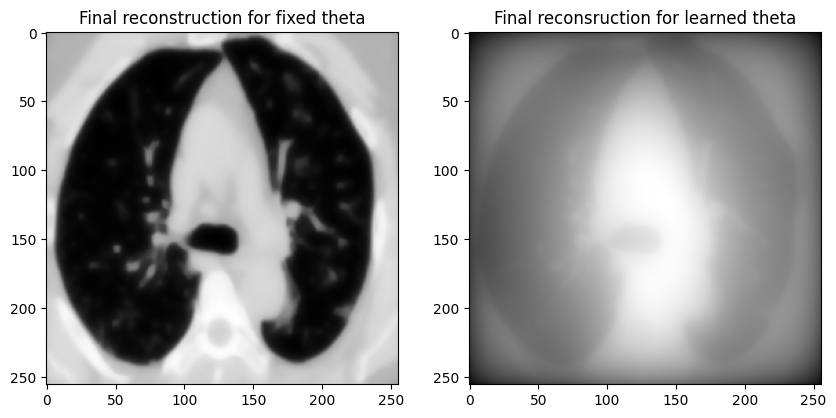

In [11]:
x_fixed = x_for_fixed_update.squeeze().cpu().numpy()
x_learned = x_for_learned_update.squeeze().cpu().numpy()
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(x_fixed, cmap='gray')
ax[0].set_title("Final reconstruction for fixed theta")
ax[1].imshow(x_learned, cmap='gray')
ax[1].set_title("Final reconsruction for learned theta")
plt.show()

In [12]:
print(sinogram_batch_noisy.size())
print(sinogram_batch.size())
print(x_batch.size())

torch.Size([25, 1, 180, 363])
torch.Size([25, 1, 180, 363])
torch.Size([25, 1, 256, 256])
